In [9]:
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

## Data preprocessing


In [ ]:
data_dir = 'datasets/mri_brain_multi'
print(os.listdir(data_dir))


['Testing', 'Training']


In [ ]:
import os
import shutil
import random

source_root = 'datasets/mri_brain_multi'  # Le dossier qui contient 'Training' et 'Testing'
target_root = 'datasets/mri_brain_multi_reduced' 
subsets = ['Training', 'Testing']
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
n_images_train = 30  # Nombre d'images par classe pour l'entraînement
n_images_test = 10   # Nombre d'images par classe pour le test (plus petit)

random.seed(42) # Pour la reproductibilité

for subset in subsets:
    # On ajuste le quota selon s'il s'agit du train ou du test
    n_to_sample = n_images_train if subset == 'Training' else n_images_test
    
    for cat in categories:
        # Création du chemin de destination
        dest_path = os.path.join(target_root, subset, cat)
        os.makedirs(dest_path, exist_ok=True)
        
        # Chemin source
        src_path = os.path.join(source_root, subset, cat)
        
        if os.path.exists(src_path):
            images = [f for f in os.listdir(src_path) if os.path.isfile(os.path.join(src_path, f))]
            
            # Vérification pour éviter de demander plus d'images qu'il n'en existe
            sample_size = min(len(images), n_to_sample)
            selected_images = random.sample(images, sample_size)
            
            # Copie des fichiers
            for img_name in selected_images:
                src_file = os.path.join(src_path, img_name)
                dst_file = os.path.join(dest_path, img_name)
                shutil.copy(src_file, dst_file)

print(f"Structure créée dans '{target_root}' avec {n_images_train} images/classe (Train) et {n_images_test} images/classe (Test).")

Structure créée dans 'mri_brain_multi_reduced' avec 30 images/classe (Train) et 10 images/classe (Test).


In [ ]:
class AddGaussianNoise(object):
    """
    Add a standard Gaussian noise."""
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

class AddRicianNoise(object):
    """
    Add a standard Rician noise.
    Formula : sqrt((I + n_re)^2 + n_im^2)
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def __call__(self, tensor):
        noise_shape = [1, tensor.size(1), tensor.size(2)]
        
        n_re = torch.randn(noise_shape) * self.sigma
        n_im = torch.randn(noise_shape) * self.sigma
        
        noisy = torch.sqrt((tensor + n_re)**2 + n_im**2)
        
        return noisy

In [8]:
from torchvision import transforms as transform

# Taille standard pour ResNet
img_size = 224

# 1. Transformations de base (communes à tous les scénarios)
# Note : Grayscale(1) est ajouté pour forcer le canal unique
base_transform = transform.Compose([
    transform.Grayscale(num_output_channels=1), 
    transform.Resize(255),
    transform.CenterCrop(img_size),
    transform.RandomHorizontalFlip(),
    transform.RandomRotation(10),
    transform.RandomAffine(translate=(0.05, 0.05), degrees=0),
    transform.ToTensor() # Sortie : Tenseur de taille (1, 224, 224)
])

# 2. Normalisation MONOCANALE (1 seule valeur au lieu de 3)
# On utilise 0.5 car les IRM sont souvent normalisées entre 0 et 1 par ToTensor()
normalize = transform.Normalize(mean=[0.5], std=[0.5])

sigma = 0.05 # Augmenté légèrement pour que l'effet soit visible à l'entraînement

# --- SCÉNARIOS D'ENTRAÎNEMENT ---

# SCÉNARIO 1 : Baseline (Standard)
train_transform_baseline = transform.Compose([
    base_transform,
    normalize
])

# SCÉNARIO 2 : Bruit Gaussien (Modèle "Sorcier")
train_transform_gaussian = transform.Compose([
    base_transform,
    AddGaussianNoise(std=sigma), 
    normalize
])

# SCÉNARIO 3 : Bruit de Rice (Votre Modèle Robuste)
train_transform_rician = transform.Compose([
    base_transform,
    AddRicianNoise(sigma=sigma), 
    normalize
])

# --- SCÉNARIO DE TEST ---
# Important : On garde le Grayscale et la normalisation monocanale
test_transform = transform.Compose([
    transform.Grayscale(num_output_channels=1),
    transform.Resize((img_size, img_size)),
    transform.ToTensor(),
    normalize
])

In [12]:
data_dir_sorted = 'mri_brain_multi_reduced' 

# --- DATASETS ---

# Entraînement : Les 3 scénarios avec leurs bruits respectifs
train_ds_base = ImageFolder(os.path.join(data_dir_sorted, 'train'), transform=train_transform_baseline)
train_ds_gauss = ImageFolder(os.path.join(data_dir_sorted, 'train'), transform=train_transform_gaussian)
train_ds_rice = ImageFolder(os.path.join(data_dir_sorted, 'train'), transform=train_transform_rician)


# Test : Sans bruit pour l'évaluation finale
test_ds = ImageFolder(os.path.join(data_dir_sorted, 'test'), transform=test_transform)

# --- LOADERS ---

batch_size = 4 # Adapté pour vos tests locaux

train_loader_base = DataLoader(train_ds_base, batch_size=batch_size, shuffle=True)
train_loader_gauss = DataLoader(train_ds_gauss, batch_size=batch_size, shuffle=True)
train_loader_rice = DataLoader(train_ds_rice, batch_size=batch_size, shuffle=True)

# Pour la validation et le test, shuffle=False pour garder l'ordre des prédictions
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Datasets chargés : {len(train_ds_base)} train, {len(train_ds_gauss)} train_gauss, {len(train_ds_rice)} train_rice, {len(test_ds)} test")

Datasets chargés : 120 train, 120 train_gauss, 120 train_rice, 40 test


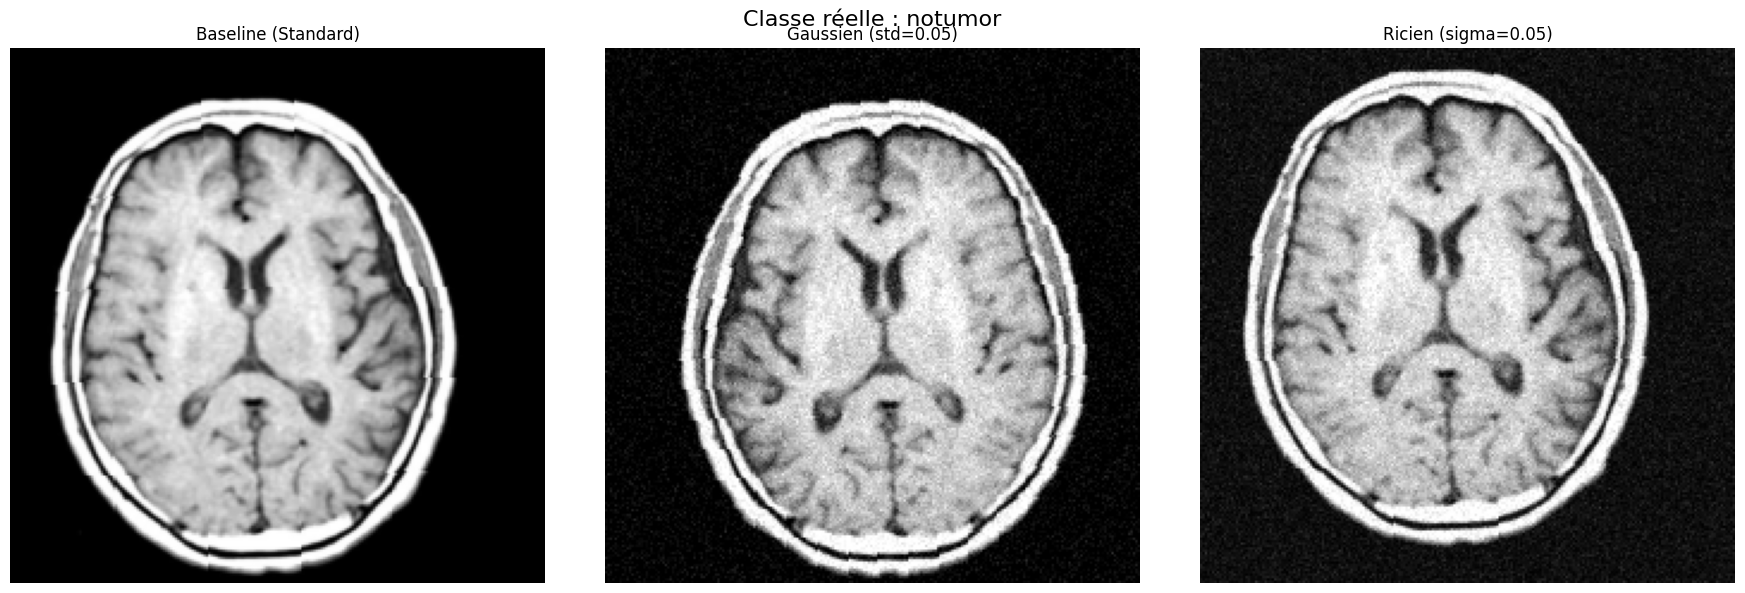

Statistiques sur l'image notumor :
Valeur min (Base) : -1.0000
Valeur min (Gauss) : -1.3777 (Centré sur la moyenne)
Valeur min (Rice) : -0.9991 (Biais positif visible)


In [21]:
import numpy as np
import matplotlib.pyplot as plt

def imshow_dataset(tensor, title=None):
    # 1. On retire la dimension du canal (1, H, W) -> (H, W)
    # .squeeze() est parfait pour passer de (1, 224, 224) à (224, 224)
    img = tensor.cpu().numpy().squeeze()
    
    # 2. On annule la normalisation monocanale (mean=0.5, std=0.5)
    # Formule : pixel_original = (pixel_norm * std) + mean
    img = (img * 0.5) + 0.5
    
    # 3. On force les valeurs entre 0 et 1 pour un affichage propre
    img = np.clip(img, 0, 1)
    
    # 4. Affichage en niveaux de gris
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')

# --- Code d'affichage ---

# On récupère l'image de chaque dataset
# Assurez-vous que vos datasets sont nommés ainsi
idx = 80

img_base, label = train_ds_base[idx]
img_gauss, _ = train_ds_gauss[idx]
img_rice, _ = train_ds_rice[idx]

# Mapping des noms de classes pour le titre global
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

plt.figure(figsize=(18, 6))
plt.suptitle(f"Classe réelle : {class_names[label]}", fontsize=16)

# Affichage Baseline
plt.subplot(1, 3, 1)
imshow_dataset(img_base, "Baseline (Standard)")

# Affichage Gaussien
plt.subplot(1, 3, 2)
imshow_dataset(img_gauss, f"Gaussien (std={sigma})")

# Affichage Ricien
plt.subplot(1, 3, 3)
imshow_dataset(img_rice, f"Ricien (sigma={sigma})")

plt.tight_layout()
plt.show()

# Vérification numérique du biais (très important pour votre slide sur le fond noir)
print(f"Statistiques sur l'image {class_names[label]} :")
print(f"Valeur min (Base) : {img_base.min():.4f}")
print(f"Valeur min (Gauss) : {img_gauss.min():.4f} (Centré sur la moyenne)")
print(f"Valeur min (Rice) : {img_rice.min():.4f} (Biais positif visible)")

## Model

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class BrainTumorResNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # 1. Charger le modèle pré-entraîné
        self.network = models.resnet50(weights='DEFAULT')
        
        # 2. Modifier la PREMIÈRE couche (conv1)
        # On récupère les paramètres de la couche existante
        original_conv = self.network.conv1
        
        self.network.conv1 = nn.Conv2d(
            in_channels=1,              # On passe de 3 à 1 canal
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias
        )
        
        # Astuce : On peut copier la moyenne des poids des 3 canaux originaux 
        # pour ne pas perdre totalement le pré-entraînement
        with torch.no_grad():
            self.network.conv1.weight[:] = original_conv.weight.mean(dim=1, keepdim=True)

        # 3. Modifier la DERNIÈRE couche (fc)
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, xb):
        return self.network(xb)

In [22]:
import torch
import torch.nn as nn
import numpy as np

def compute_accuracy(outputs, labels):
    # outputs: [batch_size, 4] (logits pour chaque classe)
    # On récupère l'indice de la valeur maximale sur la dimension 1
    _, preds = torch.max(outputs, dim=1)
    # Calcul du ratio de prédictions correctes
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_scenario(model, train_loader, test_loader, n_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Loss adaptée à la multi-classification (inclut le Softmax interne)
    criterion = nn.CrossEntropyLoss()
    
    # Optimiseur et Scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    # Historique pour les courbes d'apprentissage
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(n_epochs):
        # --- PHASE D'ENTRAÎNEMENT ---
        model.train()
        train_losses = []
        train_accs = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs) # Sortie de taille [batch_size, 4]
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_accs.append(compute_accuracy(outputs, labels).item())
        
        scheduler.step()
        
        # --- PHASE DE TEST (remplace la validation) ---
        model.eval()
        test_losses = []
        test_accs = []
        
        # Listes pour stocker les prédictions finales (pour matrice de confusion)
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                test_losses.append(loss.item())
                test_accs.append(compute_accuracy(outputs, labels).item())
                
                # Récupération des prédictions pour analyse
                _, preds = torch.max(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy().tolist())
                all_targets.extend(labels.cpu().numpy().tolist())

        # Calcul des moyennes pour l'époque
        h_train_loss = np.mean(train_losses)
        h_train_acc = np.mean(train_accs)
        h_test_loss = np.mean(test_losses)
        h_test_acc = np.mean(test_accs)

        # Enregistrement dans l'historique
        history['train_loss'].append(h_train_loss)
        history['train_acc'].append(h_train_acc)
        history['test_loss'].append(h_test_loss)
        history['test_acc'].append(h_test_acc)

        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {h_train_loss:.4f} - Acc: {h_train_acc:.4f} | Test Acc: {h_test_acc:.4f}")

    # On retourne les prédictions du dernier epoch pour la matrice de confusion
    return history, all_preds, all_targets

In [24]:
import torch

# Nombre d'époques pour l'entraînement réduit
n_epochs = 4

# 1. Entraînement BASELINE (Modèle de contrôle)
print("\n" + "="*40)
print("SCENARIO 1: TRAINING BASELINE (Standard)")
print("="*40)
model_res_base = BrainTumorResNet(num_classes=4)
history_res_base, preds_base, targets_base = train_scenario(
    model_res_base, train_loader_base, test_loader, n_epochs=n_epochs
)

# 2. Entraînement GAUSSIEN (Bruit symétrique classique)
print("\n" + "="*40)
print("SCENARIO 2: TRAINING GAUSSIAN NOISE")
print("="*40)
model_res_gauss = BrainTumorResNet(num_classes=4)
history_res_gauss, preds_gauss, targets_gauss = train_scenario(
    model_res_gauss, train_loader_gauss, test_loader, n_epochs=n_epochs
)

# 3. Entraînement RICIEN (Votre hypothèse de robustesse)
print("\n" + "="*40)
print("SCENARIO 3: TRAINING RICIAN NOISE")
print("="*40)
model_res_rician = BrainTumorResNet(num_classes=4)
history_res_rice, preds_rice, targets_rice = train_scenario(
    model_res_rician, train_loader_rice, test_loader, n_epochs=n_epochs
)

print("\n" + "="*40)
print("ALL SCENARIOS COMPLETED SUCCESSFULLY")
print("="*40)


SCENARIO 1: TRAINING BASELINE (Standard)
Epoch 1/4 - Loss: 1.0967 - Acc: 0.5667 | Test Acc: 0.6750
Epoch 2/4 - Loss: 0.6085 - Acc: 0.8250 | Test Acc: 0.6500
Epoch 3/4 - Loss: 0.6814 - Acc: 0.7333 | Test Acc: 0.8000
Epoch 4/4 - Loss: 0.4491 - Acc: 0.8833 | Test Acc: 0.8500

SCENARIO 2: TRAINING GAUSSIAN NOISE
Epoch 1/4 - Loss: 1.3571 - Acc: 0.3667 | Test Acc: 0.2750
Epoch 2/4 - Loss: 0.9030 - Acc: 0.7000 | Test Acc: 0.2500
Epoch 3/4 - Loss: 0.6694 - Acc: 0.7333 | Test Acc: 0.1750
Epoch 4/4 - Loss: 0.4423 - Acc: 0.8833 | Test Acc: 0.2500

SCENARIO 3: TRAINING RICIAN NOISE
Epoch 1/4 - Loss: 1.2644 - Acc: 0.3750 | Test Acc: 0.4000
Epoch 2/4 - Loss: 0.8586 - Acc: 0.6250 | Test Acc: 0.3500
Epoch 3/4 - Loss: 0.6795 - Acc: 0.7750 | Test Acc: 0.4000
Epoch 4/4 - Loss: 0.6367 - Acc: 0.7583 | Test Acc: 0.3750

ALL SCENARIOS COMPLETED SUCCESSFULLY
